<a href="https://colab.research.google.com/github/tumbler-lab/AutoEncoder/blob/main/VariationalAutoEncoder_ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
 
transform = transforms.Compose([
                                transforms.ToTensor(), # totensor
                                #transforms.Lambda(lambda x: x.view(-1)) # flatten
                                ])
 
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
num_workers = 4
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Definition

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class VariationalAutoEncoder(nn.Module):

    def __init__(self, z_dim):
        super(VariationalAutoEncoder, self).__init__()
        ## encoder Layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # poolした場所おぼえる
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True)
        self.linear1 = nn.Linear(7*7*32, 28*28)

        self.linear_enc1 = nn.Linear(28*28, 200)
        self.linear_enc2 = nn.Linear(200, 200)

        self.linear_mu = nn.Linear(200, z_dim) # z_dim 次元に圧縮？
        self.linear_var = nn.Linear(200, z_dim)

        ## decoder Layer
        self.linear_dec1 =  nn.Linear(z_dim, 200)
        self.linear_dec2 =  nn.Linear(200, 200)
        self.linear_dec3 =  nn.Linear(200, 28*28)

        self.t_conv1 =  nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.t_conv2 =  nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
        
        self.unpool1 = nn.MaxUnpool2d(2, 2)
        self.unpool2 = nn.MaxUnpool2d(2, 2)
        self.tlinear1 = nn.Linear(28*28, 7*7*32)

        self.sigmoid = nn.Sigmoid()
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x, a = self.pool1(x)
        x = F.relu(self.conv2(x))
        x, b = self.pool2(x)
        x = x.view(-1, 7*7*32)
        x = F.relu(self.linear1(x))

        x = F.relu(self.linear_enc1(x))
        x = F.relu(self.linear_enc2(x))
        mu = self.linear_mu(x)      # μ
        logvar = self.linear_var(x) # σ^2
        return mu, logvar, a, b
    
    def reparameterize(self, mu, var):
        std = torch.exp(0.5*logvar) 
        epsilon = torch.randn(mu.shape).to(device)
        return mean + std * epsilon
    
    def decode(self, z, a, b):
        z = F.relu(self.linear_dec1(z))
        z = F.relu(self.linear_dec2(z))
        z = F.relu(self.linear_dec3(z))

        x = F.relu(self.tlinear1(z))
        x = x.view(-1, 32, 7, 7)
        x = self.unpool1(x, b)
        x = F.relu(self.t_conv1(x))
        x = self.unpool2(x, a)
        x = torch.sigmoid(self.t_conv2(x))
        return x
    
    def forward(self, x):
        mean, var, a, b = self._encoder(x)
        z = self.reparameterize(mean, var)
        x = self._decoder(z, a, b)
        return {'x_recon': x,
                'z': z,
                'mu': mean,
                'var': var}
    
    def loss(self, outputs, x):
        x_recon = outputs['x_recon']
        mu = outputs['mu']
        logvar = torch.log(outputs['var'])

        bce = F.binary_cross_entropy(x_recon, x, reduction="sum")
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return {
            "loss": (bce + kld) / x.size(0),
            "recon_loss": bce / x.size(0),
            "kld_loss": kld / x.size(0),
        }

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = VariationalAutoEncoder(2).to(device)
print(model)

VariationalAutoEncoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=1568, out_features=784, bias=True)
  (linear_enc1): Linear(in_features=784, out_features=200, bias=True)
  (linear_enc2): Linear(in_features=200, out_features=200, bias=True)
  (linear_encmean): Linear(in_features=200, out_features=2, bias=True)
  (linear_encvar): Linear(in_features=200, out_features=2, bias=True)
  (linear_dec1): Linear(in_features=2, out_features=200, bias=True)
  (linear_dec2): Linear(in_features=200, out_features=200, bias=True)
  (linear_dec3): Linear(in_features=200, out_features=784, bias=True)
  (t_conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_co

# Training

In [ ]:
# loss function
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 30
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for data in train_loader:
        optimizer.zero_grad() # 重み初期化
        
        images, _ = data
        images = images.to(device)
        outputs = model(images)
        loss = model.loss(outputs, images)['loss']
        #loss = criterion(outputs, images) # 生成した画像と元の画像の差異

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1 	Training Loss: 84.572510
Epoch: 2 	Training Loss: 69.351944
Epoch: 3 	Training Loss: 68.567424
Epoch: 4 	Training Loss: 67.054492
Epoch: 5 	Training Loss: 66.673625
Epoch: 6 	Training Loss: 65.721039
Epoch: 7 	Training Loss: 64.817511
Epoch: 8 	Training Loss: 64.583478
Epoch: 9 	Training Loss: 64.503158
Epoch: 10 	Training Loss: 64.496976
Epoch: 11 	Training Loss: 64.158577
Epoch: 12 	Training Loss: 63.229787
Epoch: 13 	Training Loss: 62.704958
Epoch: 14 	Training Loss: 63.099417
Epoch: 15 	Training Loss: 63.088125
Epoch: 16 	Training Loss: 63.182240
Epoch: 17 	Training Loss: 63.197989
Epoch: 18 	Training Loss: 62.916329
Epoch: 19 	Training Loss: 62.961389
Epoch: 20 	Training Loss: 63.019393
Epoch: 21 	Training Loss: 63.015493
Epoch: 22 	Training Loss: 63.149060
Epoch: 23 	Training Loss: 63.296092
Epoch: 24 	Training Loss: 63.109522
Epoch: 25 	Training Loss: 63.068127
Epoch: 26 	Training Loss: 63.270387
Epoch: 27 	Training Loss: 62.951971
Epoch: 28 	Training Loss: 63.234457
E

In [ ]:
list_z_test = [] # zのリスト
list_label_test = [] # label list
model.eval()
for data in test_loader:
    images, label = data
    images = images.to(device)
    outputs = model(images)
    
    z = outputs['z']
    
    list_z_test.append(z)
    list_label_test.append(label)
array_z_test = np.concatenate([z.cpu().detach().numpy().copy() for z in list_z_test])
display(array_z_test)
array_label_test = np.concatenate([z.cpu().detach().numpy().copy() for z in list_label_test])
display(array_label_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


array([[-0.7175404 , -0.7817436 ],
       [-0.508539  ,  1.2742709 ],
       [-2.5299907 ,  1.6266867 ],
       ...,
       [-0.9279084 ,  1.5129672 ],
       [-1.0325928 , -0.8548099 ],
       [-0.23395413, -1.1979911 ]], dtype=float32)

array([7, 2, 1, ..., 4, 5, 6])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


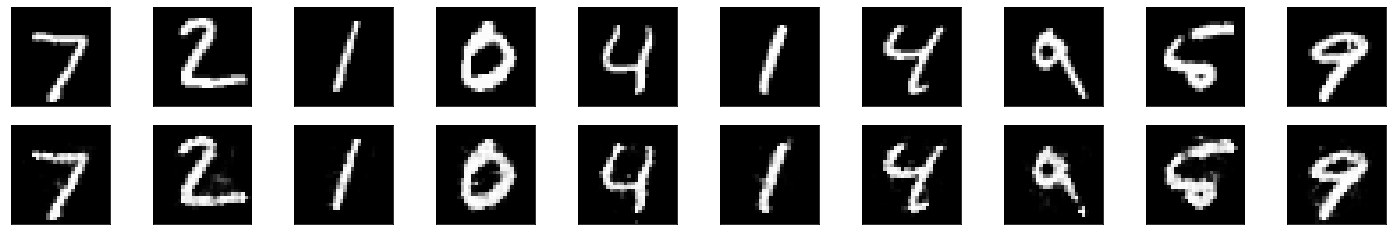

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

outputs = model(images)
images = images.view(batch_size, 1, 28, 28)
images = images.cpu().numpy()


output = outputs['x_recon'].view(batch_size, 1, 28, 28)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))

for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [ ]:
def get_mean(z_mu, y_sample, num):
    for i in range(10):
        idx = y_sample==num
    return np.mean(z_mu[idx], axis=0)

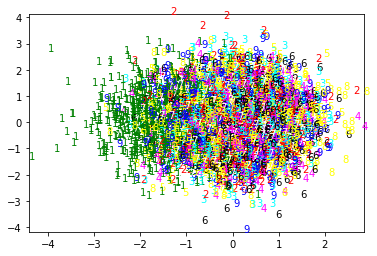

In [ ]:
import matplotlib.pyplot as plt

# dataiter =iter(train_loader)
# image_sample, label_sample = dataiter.next()
# image_sample = image_sample.to(device)
# z_mu, a, b = model.encode(image_sample)
# z_mu = z_mu.view(32,-1).detach().cpu().numpy().copy()
z_mu = array_z_test.copy()
# z_mu[:, 1] = 1

idx1, idx2 = 0, 1
plt.xlim(z_mu[:, idx1].min(), z_mu[:, idx1].max())
plt.ylim(z_mu[:, idx2].min(), z_mu[:, idx2].max())
color_dict = {0: 'blue', 1: 'green', 2: 'red', 3: 'cyan',
              4: 'magenta', 5: 'yellow', 6: 'black', 7: 'white', 8: 'yellow', 9: 'blue'}
for z, label in zip(z_mu, array_label_test):
    if label:
        plt.text(z[idx1], z[idx2], s=label.item(), color=color_dict[label.item()])
plt.show()